In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os

from datetime import timedelta, datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

## Loading dataset

no rain     48084
moderate      586
light         507
heavy         251
violent        64
Name: rain_class, dtype: int64


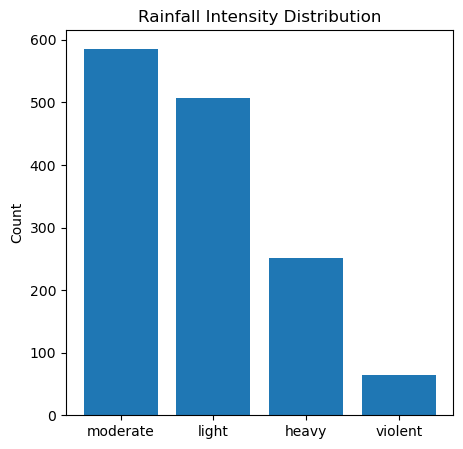

In [21]:
# Loading dataset
dataset = pd.read_csv("psd_data.csv", index_col=0, parse_dates=True)

# Count the occurrences of each rain class
print(dataset['rain_class'].value_counts())

category_counts = dataset['rain_class'].value_counts()[1:]

plt.figure(figsize=(5,5))
plt.bar(category_counts.index, category_counts.values)
plt.ylabel('Count')
plt.title('Rainfall Intensity Distribution')
plt.show()

In [23]:
dataset.head()

,total_rain,rain_class,filename,0,1,2,3,4,5,6,...,504,505,506,507,508,509,510,511,512,isolated
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-13 15:10:00,0.2,light,TBKS_20221113_151000.wav,81.873146,430.594940,815.12036,904.3106,370.8766,126.12231,103.40162,...,0.008692,0.008909,0.008647,0.008543,0.008719,0.008752,0.008772,0.009017,0.004984,False
2022-11-13 15:25:00,0.8,moderate,TBKS_20221113_152500.wav,152.264370,140.337200,4078.36300,19491.8140,10006.6010,1304.20180,1024.70140,...,0.235004,0.234566,0.234960,0.235453,0.233589,0.233405,0.234116,0.231767,0.116748,False
2022-11-13 15:30:00,0.6,moderate,TBKS_20221113_153000.wav,115.242000,438.549870,1384.69380,5255.6753,2519.2793,350.80380,297.11423,...,0.030913,0.030114,0.030113,0.030412,0.030887,0.030379,0.030153,0.030677,0.015954,False
2022-11-22 08:45:00,0.4,moderate,TBKS_20221122_084500.wav,58.523975,88.975980,686.45703,4631.1430,5170.2940,933.32420,263.30550,...,0.087185,0.086037,0.083782,0.084225,0.085419,0.084961,0.086806,0.090236,0.045160,False
2022-11-22 08:50:00,0.4,moderate,TBKS_20221122_085000.wav,22.162477,53.873272,324.81937,1726.0199,1828.7544,303.90488,103.99122,...,0.037249,0.037621,0.036670,0.037126,0.038337,0.037742,0.036612,0.036517,0.019036,False


## Running classification and regression models

In [34]:
# Set path to save csv files with rainfall estimates
csv_path = "PATH GOES HERE"

############################################################################################################################
#-------------------------------------- PART 1: SETTING UP 10 DAY TEST PERIODS FOR VALIDATION -----------------------------#
############################################################################################################################

# Define start and end dates
start_date = datetime(2023, 2, 14)
end_date = dataset.index[-1]
interval = timedelta(days=10)

# Initialize an empty list to store the result
test_periods = []

# Generate the list of strings
current_date = start_date
while current_date + interval <= end_date:
    end_of_interval = current_date + interval - timedelta(days=1)
    period_string = f"{current_date.strftime('%Y-%m-%d')} to {end_of_interval.strftime('%Y-%m-%d')}"
    test_periods.append(period_string)
    current_date += interval

for run in range(len(test_periods)):
    
    date_start = test_periods[run][0:10] + ' 00:00:00'
    date_end = test_periods[run][14:25] + ' 23:55:00'
    print(f'Now running period {test_periods[run]}')

############################################################################################################################
#-------------------------------------- PART 2: TRAINING CLASSIFICATION MODEL (RF)-----------------------------------------#
############################################################################################################################

    # Load the dataset
    dataset = pd.read_csv("psd_data.csv", index_col=0, parse_dates=True)

    # Creating rain event column
    dataset['rain'] = 0
    mask = dataset.total_rain > 0
    rain = dataset.loc[mask].index
    dataset.loc[rain, 'rain'] = 1

    # Selecting columns of interest
    dataset = dataset[['rain_class', 'total_rain', 'rain'] + [str(i) for i in range(33, 54)]]

    np.random.seed(42)
    
    # Selecting equal data of rain/no rain
    zero_rain_rows = dataset[dataset['rain'] == 0]
    selected_rows = zero_rain_rows.sample(n=sum(dataset.rain_class.value_counts()[1:]))
    dataset = pd.concat([selected_rows, dataset[dataset['rain'] == 1]])

    # Extracting 10 day test dataset
    test_ds = dataset[date_start:date_end]
    test_ds = test_ds[['rain_class', 'total_rain', 'rain'] + [str(i) for i in range(33, 54)]]
    
    # Dropping 10 day test period from training dataset
    dataset.drop(index=test_ds.index, inplace=True)

    # Selecting X and y for classification
    X_class = dataset[dataset.columns[3:]].iloc[:, :].values
    y_class = dataset.rain.values

    # Random Forest Classifier Grid Search
    rf_classifier = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    cv_classifier = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
    cv_classifier.fit(X_class, y_class)

############################################################################################################################
#------------------------------------ PART 3: PREPARING DATA AND TRAINING REGRESSION MODELS -------------------------------#
############################################################################################################################

    # Integrating PSD for linear regression
    X_train_linear_reg = pd.DataFrame(dataset[dataset.columns[3:]].mean(axis=1)).values
    
    # Selecting PSD values for RF and GB
    X = dataset[dataset.columns[3:]].iloc[:, :].values
    
    # Selecting rain gauge measurements
    y = dataset.total_rain.values

    # Selecting validation X and y from 10 day test dataset
    X_test_linear_reg = test_ds[test_ds.columns[3:]].mean(axis=1).values
    X_test_ds = test_ds[test_ds.columns[3:]].iloc[:, :].values
    y_test_ds = test_ds.total_rain.values

    # Initialize regression models
    linear_reg = LinearRegression()
    rf_regressor = RandomForestRegressor(random_state=42)
    gb_regressor = GradientBoostingRegressor(random_state=42)

    # Perform 5-fold cross-validation for regression models
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    results_linear = []
    results_rf = []
    results_gb = []

############################################################################################################################
#-------------------------------------- PART 4: VALIDATING MODELS ON TEST DATASET -----------------------------------------#
############################################################################################################################

    # Loop through train and test indices using KFold cross-validation
    for train_index, test_index in kf.split(X):
        
        # Split the data into train and test sets for all models
        X_train, X_test = X[train_index], X[test_index]  # Features for random forest and gradient boosting
        y_train, y_test = y[train_index], y[test_index]  # Target values for all models

        # Train and predict using Linear Regression model
        linear_reg.fit(X_train_linear_reg, y_train)  # Train linear regression with X_train_linear_reg features
        y_pred_linear = linear_reg.predict(X_test_linear_reg.reshape(-1, 1))  # Predict using X_test_linear_reg features
        results_linear.extend(y_pred_linear)  # Extend results_linear list with linear regression predictions

        # Train and predict using Random Forest Regressor model
        rf_regressor.fit(X_train, y_train)  # Train random forest regressor with X_train features
        y_pred_rf = rf_regressor.predict(X_test)  # Predict using X_test features
        results_rf.extend(y_pred_rf)  # Extend results_rf list with random forest predictions

        # Train and predict using Gradient Boosting Regressor model
        gb_regressor.fit(X_train, y_train)  # Train gradient boosting regressor with X_train features
        y_pred_gb = gb_regressor.predict(X_test)  # Predict using X_test features
        results_gb.extend(y_pred_gb)  # Extend results_gb list with gradient boosting predictions

    classifier_predictions = cv_classifier.predict(X_test_ds)

    final_results = []
    
    for i in range(len(classifier_predictions)):
        
        # If classifier detects rainfall, run regression model
        if classifier_predictions[i] == 1:
            rf_prediction = rf_regressor.predict([X_test_ds[i]])[0]
            gb_prediction = gb_regressor.predict([X_test_ds[i]])[0]
            linear_prediction = linear_reg.predict([X_test_linear_reg.reshape(-1, 1)[i]])[0]
            final_results.append([y_test_ds[i], linear_prediction, rf_prediction, gb_prediction])
            
        # If rain not detected, total rain equals to zero
        else:
            final_results.append([y_test_ds[i], 0, 0, 0])

    # Create a DataFrame with the results
    df_results = pd.DataFrame(final_results, columns=['y_test', 'y_linear', 'y_rf', 'y_gb'], index=test_ds.index)
    
    # Saving dataframe with validation results
    df_results.to_csv(f"{test_periods[run]}.csv")
    print(fr'{csv_path}\{test_periods[run]}.csv saved successfully!\n')

Now running period 2023-02-14 to 2023-02-23


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-02-14 to 2023-02-23.csv saved successfully!

Now running period 2023-02-24 to 2023-03-05


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-02-24 to 2023-03-05.csv saved successfully!

Now running period 2023-03-06 to 2023-03-15


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-03-06 to 2023-03-15.csv saved successfully!

Now running period 2023-03-16 to 2023-03-25


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-03-16 to 2023-03-25.csv saved successfully!

Now running period 2023-03-26 to 2023-04-04


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-03-26 to 2023-04-04.csv saved successfully!

Now running period 2023-04-05 to 2023-04-14


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-04-05 to 2023-04-14.csv saved successfully!

Now running period 2023-04-15 to 2023-04-24


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-04-15 to 2023-04-24.csv saved successfully!

Now running period 2023-04-25 to 2023-05-04


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-04-25 to 2023-05-04.csv saved successfully!

Now running period 2023-05-05 to 2023-05-14


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-05-05 to 2023-05-14.csv saved successfully!

Now running period 2023-05-15 to 2023-05-24


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-05-15 to 2023-05-24.csv saved successfully!

Now running period 2023-05-25 to 2023-06-03


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-05-25 to 2023-06-03.csv saved successfully!

Now running period 2023-06-04 to 2023-06-13


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-06-04 to 2023-06-13.csv saved successfully!

Now running period 2023-06-14 to 2023-06-23


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-06-14 to 2023-06-23.csv saved successfully!

Now running period 2023-06-24 to 2023-07-03


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-06-24 to 2023-07-03.csv saved successfully!

Now running period 2023-07-04 to 2023-07-13


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-07-04 to 2023-07-13.csv saved successfully!

Now running period 2023-07-14 to 2023-07-23


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-07-14 to 2023-07-23.csv saved successfully!

Now running period 2023-07-24 to 2023-08-02


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-07-24 to 2023-08-02.csv saved successfully!

Now running period 2023-08-03 to 2023-08-12


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-08-03 to 2023-08-12.csv saved successfully!

Now running period 2023-08-13 to 2023-08-22


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-08-13 to 2023-08-22.csv saved successfully!

Now running period 2023-08-23 to 2023-09-01


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-08-23 to 2023-09-01.csv saved successfully!

Now running period 2023-09-02 to 2023-09-11


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-09-02 to 2023-09-11.csv saved successfully!

Now running period 2023-09-12 to 2023-09-21


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-09-12 to 2023-09-21.csv saved successfully!

Now running period 2023-09-22 to 2023-10-01


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-09-22 to 2023-10-01.csv saved successfully!

Now running period 2023-10-02 to 2023-10-11


C:\Users\55149\AppData\Local\Temp\ipykernel_19008\3429384813.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_ds = dataset[date_start:date_end]


2023-10-02 to 2023-10-11.csv saved successfully!



## Plotting results

In [2]:
# List CSV files in the folder
csv_files = [file for file in os.listdir(csv_path) if file.endswith('.csv')]

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through CSV files and read them into DataFrames
for csv_file in csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path,index_col=0,parse_dates=True)  # Read CSV into DataFrame
    dfs.append(df)  # Add DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=False)
df['y_linear'] = df['y_linear'].round(decimals=1)
df['y_rf'] = df['y_rf'].round(decimals=1)
df['y_gb'] = df['y_gb'].round(decimals=1)

In [7]:
# Calculate True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
TP = len(df[(df['y_test'] > 0) & (df['y_rf'] > 0)])
FP = len(df[(df['y_test'] == 0) & (df['y_rf'] > 0)])
TN = len(df[(df['y_test'] == 0) & (df['y_rf'] == 0)])
FN = len(df[(df['y_test'] > 0) & (df['y_rf'] == 0)])

# Calculate Probability of Detection (POD) and False Alarm Rate (FAR)
POD = TP / (TP + FN)  # Probability of Detection
FAR = FP / (FP + TN)  # False Alarm Rate

# Print the results
print("Probability of Detection (POD):", POD)
print("False Alarm Rate (FAR):", FAR)

Probability of Detection (POD): 0.946396664681358
False Alarm Rate (FAR): 0.053206997084548104


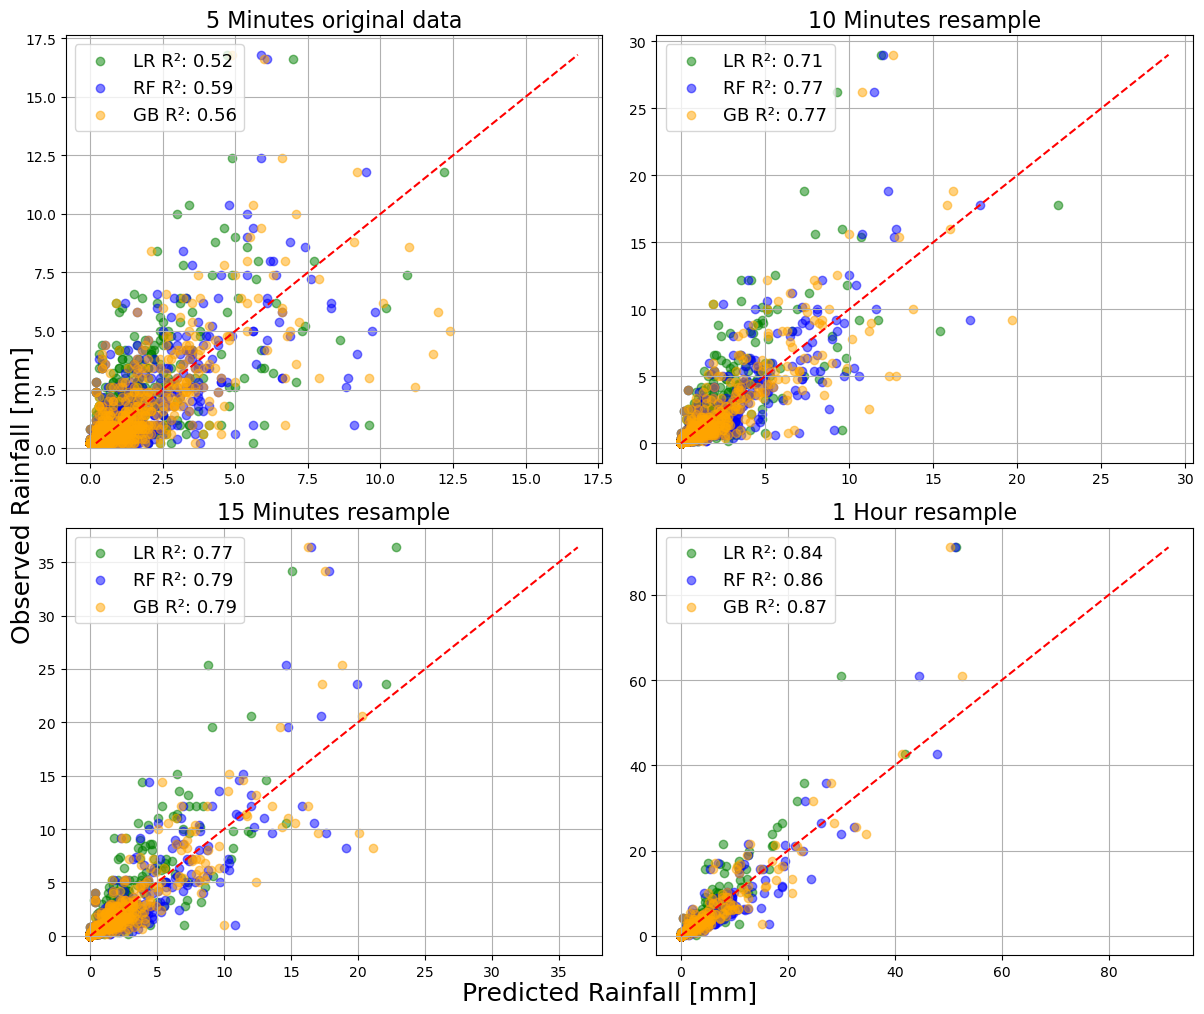

In [14]:
# Filter rows where y_test is greater than 0
filtered_df = df[df['y_test'] > 0]

# Resample the DataFrame for different time intervals
resampled_df_10min = filtered_df.resample('10T').sum()  # 10 minutes sum
resampled_df_15min = filtered_df.resample('15T').sum()  # 15 minutes sum
resampled_df_1hour = filtered_df.resample('1H').sum()   # 1 hour sum

# Extract y_test and y_rf values for different resampling intervals
y_test_values = filtered_df['y_test']
y_rf_values = filtered_df['y_rf']
y_gb_values = filtered_df['y_gb']
y_lr_values = filtered_df['y_linear']

y_test_values_10min = resampled_df_10min['y_test']
y_rf_values_10min = resampled_df_10min['y_rf']
y_gb_values_10min = resampled_df_10min['y_gb']
y_lr_values_10min = resampled_df_10min['y_linear']

y_test_values_15min = resampled_df_15min['y_test']
y_rf_values_15min = resampled_df_15min['y_rf']
y_gb_values_15min = resampled_df_15min['y_gb']
y_lr_values_15min = resampled_df_15min['y_linear']

y_test_values_1hour = resampled_df_1hour['y_test']
y_rf_values_1hour = resampled_df_1hour['y_rf']
y_gb_values_1hour = resampled_df_1hour['y_gb']
y_lr_values_1hour = resampled_df_1hour['y_linear']

# Calculate R² for 10 minutes resampled data
r2_lr_5min = r2_score(y_test_values, y_lr_values)
r2_rf_5min = r2_score(y_test_values, y_rf_values)
r2_gb_5min = r2_score(y_test_values, y_gb_values)

# Calculate R² for 10 minutes resampled data
r2_lr_10min = r2_score(y_test_values_10min, y_lr_values_10min)
r2_rf_10min = r2_score(y_test_values_10min, y_rf_values_10min)
r2_gb_10min = r2_score(y_test_values_10min, y_gb_values_10min)

# Calculate R² for 15 minutes resampled data
r2_lr_15min = r2_score(y_test_values_15min, y_lr_values_15min)
r2_rf_15min = r2_score(y_test_values_15min, y_rf_values_15min)
r2_gb_15min = r2_score(y_test_values_15min, y_gb_values_15min)

# Calculate R² for 1 hour resampled data
r2_lr_1hour = r2_score(y_test_values_1hour, y_lr_values_1hour)
r2_rf_1hour = r2_score(y_test_values_1hour, y_rf_values_1hour)
r2_gb_1hour = r2_score(y_test_values_1hour, y_gb_values_1hour)

# Calculate R² = 1 line
x_line = np.linspace(min(y_test_values), max(y_test_values), 100)
y_line = x_line  # R² = 1 line

x_line_10min = np.linspace(min(y_test_values_10min), max(y_test_values_10min), 100)
y_line_10min = x_line_10min

x_line_15min = np.linspace(min(y_test_values_15min), max(y_test_values_15min), 100)
y_line_15min = x_line_15min

x_line_1hour = np.linspace(min(y_test_values_1hour), max(y_test_values_1hour), 100)
y_line_1hour = x_line_1hour

# Create a 2 by 2 grid of scatter plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Adjust layout and set main x and y labels
plt.tight_layout(pad=3.0, w_pad=5.0, h_pad=2.0)
fig.text(0.5, 0.002, 'Predicted Rainfall [mm]', ha='center', va='center', fontsize=18)  # Increase font size for x-axis label
fig.text(0.01, 0.5, 'Observed Rainfall [mm]', ha='center', va='center', rotation='vertical', fontsize=18)  # Increase font size for y-axis label

# Plot the original data (5 minutes)
axes[0, 0].scatter(y_lr_values, y_test_values, color='green', label=f'LR R²: {r2_lr_5min:.2f}', alpha=0.5)
axes[0, 0].scatter(y_rf_values, y_test_values, color='blue', label=f'RF R²: {r2_rf_5min:.2f}', alpha=0.5)
axes[0, 0].scatter(y_gb_values, y_test_values, color='orange', label=f'GB R²: {r2_gb_5min:.2f}', alpha=0.5)
axes[0, 0].plot(x_line, y_line, color='red', linestyle='--')
axes[0, 0].set_title('5 Minutes original data', fontsize=16)
axes[0, 0].legend(fontsize=13,loc='upper left')
axes[0, 0].grid(True)

# Plot data resampled for 10 minutes sum
axes[0, 1].scatter(y_lr_values_10min, y_test_values_10min, color='green', label=f'LR R²: {r2_lr_10min:.2f}', alpha=0.5)
axes[0, 1].scatter(y_rf_values_10min, y_test_values_10min, color='blue', label=f'RF R²: {r2_rf_10min:.2f}', alpha=0.5)
axes[0, 1].scatter(y_gb_values_10min, y_test_values_10min, color='orange', label=f'GB R²: {r2_gb_10min:.2f}', alpha=0.5)
axes[0, 1].plot(x_line_10min, y_line_10min, color='red', linestyle='--')
axes[0, 1].set_title('10 Minutes resample', fontsize=16)
axes[0, 1].legend(fontsize=13,loc='upper left')
axes[0, 1].grid(True)

# Plot data resampled for 15 minutes sum
axes[1, 0].scatter(y_lr_values_15min, y_test_values_15min, color='green', label=f'LR R²: {r2_lr_15min:.2f}', alpha=0.5)
axes[1, 0].scatter(y_rf_values_15min, y_test_values_15min, color='blue', label=f'RF R²: {r2_rf_15min:.2f}', alpha=0.5)
axes[1, 0].scatter(y_gb_values_15min, y_test_values_15min, color='orange', label=f'GB R²: {r2_rf_15min:.2f}', alpha=0.5)
axes[1, 0].plot(x_line_15min, y_line_15min, color='red', linestyle='--')
axes[1, 0].set_title('15 Minutes resample', fontsize=16)
axes[1, 0].legend(fontsize=13,loc='upper left')
axes[1, 0].grid(True)

# Plot data resampled for 1 hour sum
axes[1, 1].scatter(y_lr_values_1hour, y_test_values_1hour, color='green', label=f'LR R²: {r2_lr_1hour:.2f}', alpha=0.5)
axes[1, 1].scatter(y_rf_values_1hour, y_test_values_1hour, color='blue', label=f'RF R²: {r2_rf_1hour:.2f}', alpha=0.5)
axes[1, 1].scatter(y_gb_values_1hour, y_test_values_1hour, color='orange', label=f'GB R²: {r2_gb_1hour:.2f}', alpha=0.5)
axes[1, 1].plot(x_line_1hour, y_line_1hour, color='red', linestyle='--')
axes[1, 1].set_title('1 Hour resample', fontsize=16)
axes[1, 1].legend(fontsize=13,loc='upper left')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
df.sum()

y_test      1337.6
y_linear    1098.0
y_rf        1418.8
y_gb        1352.2
dtype: float64

In [22]:
print(f'Total false alarm rainfall for LR: {df.loc[df.y_test == 0].y_linear.sum().round(decimals=1)} mm')
print(f'Total false alarm rainfall for RF: {df.loc[df.y_test == 0].y_rf.sum().round(decimals=1)} mm')
print(f'Total false alarm rainfall for GB: {df.loc[df.y_test == 0].y_gb.sum().round(decimals=1)} mm')

Total false alarm rainfall for LR: 19.8 mm
Total false alarm rainfall for RF: 18.7 mm
Total false alarm rainfall for GB: 17.6 mm


In [10]:
os.chdir(r"C:\Users\55149\OneDrive\Documentos\Sound of rainfall")

r2_lr = []
r2_rf = []
r2_gb = []

for file in os.listdir(r"C:\Users\55149\OneDrive\Documentos\Sound of rainfall"):
    
    df = pd.read_csv(file,index_col=0,parse_dates=True)
    df = df[df['y_test'] > 0]
    
    try:
        r2_lr.append(r2_score(df.y_test.values, df.y_linear.values))
        r2_rf.append(r2_score(df.y_test.values, df.y_rf.values))
        r2_gb.append(r2_score(df.y_test.values, df.y_gb.values))
        
    except ValueError:
        r2_lr.append(0)
        r2_rf.append(0)
        r2_gb.append(0)

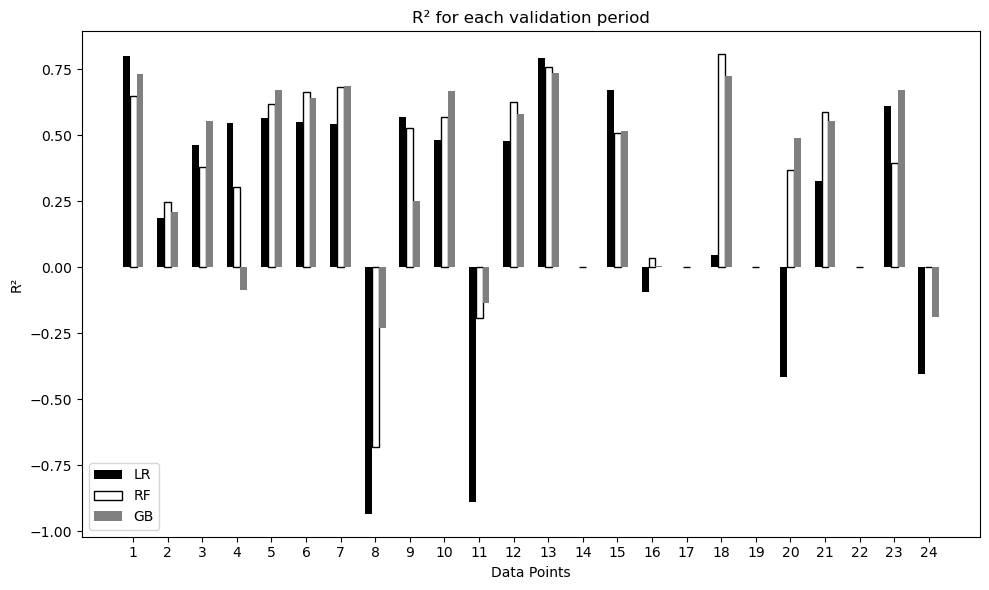

In [20]:
# X-axis positions for the groups
x = np.arange(len(r2_lr))

# Width of each bar
bar_width = 0.2  # You can adjust this value based on your preference

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(x, r2_lr, width=bar_width, label='LR',color='black')
plt.bar(x + bar_width, r2_rf, width=bar_width, label='RF',color='white',edgecolor='black')
plt.bar(x + 2 * bar_width, r2_gb, width=bar_width, label='GB',color='gray')

# Set labels, title, and legend
plt.xlabel('Data Points')
plt.ylabel('R²')
plt.title('R² for each validation period')
plt.xticks(x + bar_width, range(1, len(r2_lr) + 1))  # Assuming data points are numbered from 1 to num_points
plt.legend()

# Show the plot
plt.tight_layout()  # Ensures labels fit within the figure area
plt.show()